In [1]:
import numpy as np
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import time
from IPython import display
from grids import StochOccupancyGrid2D
from grids import DetOccupancyGrid2D as DO
from astar import AStar
%matplotlib inline

In [2]:
# A 2D state space grid with a set of rectangular obstacles. The grid is fully deterministic
class DetOccupancyGrid2D(object):
    def __init__(self, width, height, obstacles, resolution):
        self.width = width
        self.height = height
        self.obstacles = obstacles
        self.resolution = resolution
        self.grid = []
        # build numpy grid array
        self.grid_compute()

    def is_free(self, x):
        for obs in self.obstacles:
            inside = True
            for dim in range(len(x)):
                if x[dim] < obs[0][dim] or x[dim] > obs[1][dim]:
                    inside = False
                    break
            if inside:
                return False
        return True

    def plot(self, fig_num=0):
        fig = plt.figure(fig_num)
        for obs in self.obstacles:
            ax = fig.add_subplot(111, aspect='equal')
            ax.add_patch(
            patches.Rectangle(
            obs[0],
            obs[1][0]-obs[0][0],
            obs[1][1]-obs[0][1],))
    
    def grid_compute(self):
        x_dis = int(round(self.width/self.resolution))+1
        y_dis = int(round(self.height/self.resolution))+1
        self.grid = np.zeros((x_dis,y_dis))
        for i in range(len(self.obstacles)):
            x_bottom_ind = int(round(self.obstacles[i][0][0]/self.resolution))
            x_top_ind = int(round(self.obstacles[i][1][0]/self.resolution))
            y_bottom_ind = int(round(self.obstacles[i][0][1]/self.resolution))
            y_top_ind = int(round(self.obstacles[i][1][1]/self.resolution))
            self.grid[x_bottom_ind:x_top_ind+1,y_bottom_ind:y_top_ind+1] = 1

In [3]:
def snap_to_grid(world, x):
    return (world.resolution*round(x[0]/world.resolution), world.resolution*round(x[1]/world.resolution))

def location_ind(world, x):
    return (int(round(x[0]/world.resolution)), int(round(x[1]/world.resolution)))

def ind_to_cartesian(world, ind):
    x_car = world.resolution*ind[0]
    y_car = world.resolution*ind[1]
    return (x_car, y_car)

In [4]:
def generate_initial_location(world):
    free = False
    while not free:
        x = np.random.uniform(0, world.width)
        y = np.random.uniform(0, world.height)
        free = world.is_free(snap_to_grid(world,(x,y)))
    return snap_to_grid(world, (x,y))

In [5]:
def update_rmap(world, rmap, location, rrange=1):
    # world gets padded
    rrange = int(np.ceil(rrange))
    world_padded = np.pad(world.grid,rrange,mode='constant')
    rmap_padded = np.pad(rmap,rrange,mode='constant')
    rrange_ind = int(round(rrange/world.resolution))
    x_world_ind, y_world_ind = location_ind(world, location)
    x_pad_ind = x_world_ind + rrange
    y_pad_ind = y_world_ind + rrange
    
    ### measurement assuming 'x-ray' vision (ie. no occlusion) -> not available to robot
    #world.grid[(x_world_ind,y_world_ind)] = 3
    #world_padded[(x_pad_ind,y_pad_ind)] = 3 #robot marking
    x_min_full = max(0, x_pad_ind-rrange_ind)
    x_max_full = min(world_padded.shape[0]-1, x_pad_ind+rrange_ind)
    y_min_full = max(0, y_pad_ind-rrange_ind)
    y_max_full = min(world_padded.shape[1]-1, y_pad_ind+rrange_ind)
    full_measurement = np.copy(world_padded[x_min_full:x_max_full+1, y_min_full:y_max_full+1])
    occluded = np.copy(full_measurement)
    ###
    
            #print('world')
            #print(world.grid)
            #print('world (padded)')
            #print(world_padded)
            #print('rmap')
            #print(rmap)
            #print('full measurement:')
            #print(full_measurement)
    
    
    # find local area without going beyond occlusions
    r = 0
    measurement = np.zeros(0)
    while measurement.any() != 1 and r < rrange_ind:
        r += 1
        x_min_measure = max(0, x_pad_ind-r)
        x_max_measure = min(world_padded.shape[0]-1, x_pad_ind+r)
        y_min_measure = max(0, y_pad_ind-r)
        y_max_measure = min(world_padded.shape[1]-1, y_pad_ind+r)
        measurement = world_padded[x_min_measure:x_max_measure+1, y_min_measure:y_max_measure+1]
    #print('measurement pre')
    #print(measurement)   
    #print((x_min_measure,x_max_measure,y_min_measure,y_max_measure))

    ####
    
    x_min_flag = False
    while not x_min_flag:
        if world_padded[x_min_measure,max(y_pad_ind-r,0):min(y_pad_ind+r+1,world_padded.shape[1]-1)].any() == 1 or (x_min_measure <= max(x_pad_ind - rrange_ind,0)):
            x_min_flag = True
        else:
            x_min_measure = x_min_measure - 1
    
    x_max_flag = False
    while not x_max_flag:
        if world_padded[x_max_measure,max(y_pad_ind-r,0):min(y_pad_ind+r+1,world_padded.shape[1]-1)].any() == 1 or (x_max_measure >= min(x_pad_ind + rrange_ind,world_padded.shape[0]-1)):
            x_max_flag = True
        else:
            x_max_measure += 1      
        #print('x_max_measure')
        #print(x_max_measure)
    
    y_min_flag = False
    while not y_min_flag:
        if world_padded[max(x_pad_ind-r,0):min(x_pad_ind+r+1,world_padded.shape[0]-1),y_min_measure].any() == 1 or (y_min_measure <= max(y_pad_ind - rrange_ind,0)):
            y_min_flag = True
        else:
            y_min_measure = y_min_measure - 1
        
    y_max_flag = False
    while not y_max_flag:
        if world_padded[max(x_pad_ind-r,0):min(x_pad_ind+r+1,world_padded.shape[1]-1),y_max_measure].any() == 1 or (y_max_measure >= min(y_pad_ind + rrange_ind,world_padded.shape[0]-1)):
            y_max_flag = True
        else:
            y_max_measure = y_max_measure + 1      
    
    #print('measurement post')
    #print((x_min_measure,x_max_measure,y_min_measure,y_max_measure))
    measurement_post = world_padded[x_min_measure:x_max_measure+1, y_min_measure:y_max_measure+1]
    #print(measurement_post) 
    ######
    
    
    # find occlusions and remove information from 'full' measurement
    #if measurement.any() == 1 and r <= rrange_ind:
    while r <= rrange_ind:
        x_mi = max(0, x_pad_ind-r)
        x_ma = min(world_padded.shape[0]-1, x_pad_ind+r)
        y_mi = max(0, y_pad_ind-r)
        y_ma = min(world_padded.shape[1]-1, y_pad_ind+r)
        meas = world_padded[x_mi:x_ma+1, y_mi:y_ma+1]
        row, col = np.where(meas==1)
        for i in range(len(row)):
            r_aug = row[i]+(rrange_ind-r)
            c_aug = col[i]+(rrange_ind-r)
            if row[i] > meas.shape[0]/2:
                x_min = r_aug
                x_max = full_measurement.shape[0]-1
            else:
                x_min = 0
                x_max = r_aug
                
            if col[i] > meas.shape[1]/2:
                y_min = c_aug
                y_max = full_measurement.shape[1]-1
            else:
                y_min = 0
                y_max = c_aug
            
            
            occluded[x_min:x_max+1,y_min:y_max+1] = -1 
                        
            #print('r,c')
            #print((r_aug,c_aug))
            #print('xmin')
            #print(x_min)
            #print('xmax')
            #print(x_max)
            #print('ymin')
            #print(y_min)
            #print('ymax')
            #print(y_max)
                        
            #print('current occlusion')
            #print(occluded)
        r+=1 
    
    ### update rmap  
            #print('rmap')
            #print(rmap)
            #print('occluded')
            #print(occluded)
            #print('measurement')
            #print(measurement)
    # create masks
    measurement_mask = -1*np.ones(rmap_padded.shape)
    #print('measurement shape')
    #print(measurement.shape)
    #print('rmap size')
    #print(rmap.shape)
    measurement_mask[x_min_measure:x_max_measure+1, y_min_measure:y_max_measure+1] = measurement_post
    #measurement_mask[x_min_full:x_max_full+1, y_min_full:y_max_full+1] = full_measurement
    measurement_mask = measurement_mask[rrange:-rrange,rrange:-rrange] #remove padding
    occluded_mask = -1*np.ones(rmap_padded.shape)
    occluded_mask[x_min_full:x_max_full+1, y_min_full:y_max_full+1] = occluded
    occluded_mask = occluded_mask[rrange:-rrange,rrange:-rrange] #remove padding
    
    for i in range(rmap.shape[0]):
        for j in range(rmap.shape[1]):
            if measurement_mask[i,j] != -1:
                rmap[i,j] = measurement_mask[i,j]
            if occluded_mask[i,j] != -1:
                rmap[i,j] = occluded_mask[i,j]
    
            #print(measurement_mask)
            #print(occluded_mask)
            #print(rmap)

            #rmap_padded[x_min_measure:x_max_measure+1, y_min_measure:y_max_measure+1] = measurement

            #rmap_padded[x_min_full:x_max_full+1, y_min_full:y_max_full+1] = occluded
            #print('after occlusion')
            #print(occluded)
            #print('new rmap')
            #print(rmap)
    return rmap

In [6]:
def find_closest_unexplored(world, rmap, location):
    known = np.zeros(rmap.shape)
    known[np.where(rmap == 0)] = 1
    known_dilated = scipy.ndimage.morphology.binary_dilation(known)
    test_cases = known_dilated - known
    
    distance = np.zeros(rmap.shape)
    x_ind, y_ind = location_ind(world, location)
    for i in range(rmap.shape[0]):
        for j in range(rmap.shape[1]):
            if test_cases[i,j] == 1 and rmap[i,j] != 1:
                distance[i,j] = np.sqrt((x_ind - i)**2 + (y_ind -j)**2)
            else:
                distance[i,j] = np.infty
    closest_ind = np.unravel_index(distance.argmin(), distance.shape)
    
    return ind_to_cartesian(world, closest_ind)

In [7]:
def plot_exploration(world, rmap, location):
    # make a color map of fixed colors
    rmap_loc = np.copy(rmap) # make a copy with robot location for visualization
    cmap = colors.ListedColormap(['grey','white','black','red'])
    bounds=[-1.5,-.75,.75,1.5,2.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    rmap_loc[location_ind(world, location)] = 2 # include current location of robot
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(world.grid.T,cmap=cmap,origin='lower',interpolation='none',norm=norm, extent=[0,world.width,0,world.height])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(rmap_loc.T,cmap=cmap,origin='lower',interpolation='none',norm=norm, extent=[0,world.width,0,world.height])

In [8]:
def find_explore_location(world, rmap, location):
    unexplored = np.zeros(rmap.shape) # binary: explored (0), unexplored (1) matrix
    unexplored[np.where(rmap==-1)] = 1 # set all unexplored regions to 1
    lbl = scipy.ndimage.label(unexplored)[0] # automatically labels "clusters" with different values (1,2,3...)
    com_options_ind = scipy.ndimage.measurements.center_of_mass(unexplored, lbl,np.unique(lbl)[1:]) # find center(s) of mass

    # if no centroid is found, simply go to closest unexplored location
    if com_options_ind == []:
        #print('no centroid found: going to nearest frontier')
        return find_closest_unexplored(world, rmap, location)
    
    # if options exist, select the option with the most area
    else:
        counts = np.bincount(lbl[np.where(lbl != 0)].ravel())
        #print('Number of centroids:')
        #print(len(counts)-1)
        best_idx = np.argmax(counts)-1
        com = ind_to_cartesian(world, com_options_ind[best_idx])
        #print('Current centroid:')
        #print(com)
        
        # if center of mass is within the unexplored region, new explore location has been found
        if unexplored[location_ind(world, com)] == 1: 
            #print('best center of mass works')
            #print('Current centroid:')
            #print(com)
            return com
        else:
            # if center of mass is outside unexplored region, we try splitting cluster via erosion to find new com
            # NOTE: may be better to try other calculated com's from above instead of directly trying erosion
            
            temp = np.copy(unexplored)
            while unexplored[location_ind(world, com)] != 1:
                print('erosion...')
                temp = scipy.ndimage.morphology.binary_erosion(temp) # erode unexplored region
                lbl = scipy.ndimage.label(temp)[0] # automatically labels "clusters" with different values (1,2,3...)
                com_options_ind = scipy.ndimage.measurements.center_of_mass(temp, lbl,np.unique(lbl)[1:]) # find new center(s) of mass

                # if no centroid is found, simply go to closest unexplored location
                if com_options_ind == []:
                    #print('frontier exploration broken')
                    return find_closest_unexplored(world, rmap, location)

                # if multiple clusters have been found, select the one with the most area
                else:
                    counts = np.bincount(lbl[np.where(lbl != 0)].ravel())
                    best_idx = np.argmax(counts)-1
                    com = ind_to_cartesian(world, com_options_ind[best_idx])
                    if unexplored[location_ind(world, com)] == 1: 
                        #print('Current centroid:')
                        #print(com)
                        return com  

In [9]:
def plot_new_location_in_unexplored(world, rmap, location, new_location):
    rmap_loc = np.copy(rmap) # make a copy with robot location for visualization
    cmap = colors.ListedColormap(['grey','white','black','red','purple'])
    bounds=[-1.5,-.5,.5,1.5,2.5,3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    rmap_loc[location_ind(world, new_location)] = 3 # new location to navigate towards
    rmap_loc[location_ind(world, location)] = 2 # include current location of robot
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(world.grid.T,cmap=cmap,origin='lower',interpolation='none',norm=norm, extent=[0,world.width,0,world.height])
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(rmap_loc.T,cmap=cmap,origin='lower',interpolation='none',norm=norm, extent=[0,world.width,0,world.height])

In [36]:
class explorer:
    def __init__(self, world, rrange):
        self.world = world
        # initialize robot
        self.rmap = -1*np.ones(self.world.grid.shape) # initially unexplored
        self.location = generate_initial_location(self.world) # random initial location 
        self.rrange = rrange # range of robot 'LIDAR' scanning in grid cells
        self.new_location = self.location # initialize next location
        self.x_traj = []
        self.y_traj = []
        
    def display(self, title=0, iteration=0):
        plot_new_location_in_unexplored(self.world, self.rmap, self.location, self.new_location)
        plt.plot(self.x_traj,self.y_traj,'g-o')
        plt.xlim([0, world.width])
        plt.ylim([0, world.height])
        if title == 1:
            if iteration == 0:
                plt.suptitle("Exploration")
            elif iteration > 0:
                plt.suptitle("Exploration: iteration %i" % (iteration))

        display.display(plt.gcf())
        display.clear_output(wait=True)


    def run(self, iterations, timeDelay=1.0):
        self.display(1)
        time.sleep(1)

        for i in range(iterations):
            # update rmap
            self.rmap = update_rmap(self.world, self.rmap, self.location, self.rrange) 
            
            # find new location and get trajectory
            self.new_location = find_explore_location(self.world, self.rmap, self.location)
            self.x_traj, self.y_traj = get_path(self.world, self.rmap, self.location, self.new_location)
            for i in range(len(self.x_traj)):
                self.location = (self.x_traj[i],self.y_traj[i])
                self.rmap = update_rmap(self.world, self.rmap, self.location, self.rrange) 

                
            
            self.display(1,i+1);
            time.sleep(timeDelay)
            
            # now @ new_location
            self.location = self.new_location
            
        display.clear_output(wait=True)

In [37]:
def grid_to_occupancy(world, rmap, origin=(0,0), robot_size=1):
    temp = np.copy(rmap)
    temp[np.where(rmap == 1)] = 100
    occupancy = StochOccupancyGrid2D(world.resolution, world.width, world.height, origin[0], origin[1], robot_size, temp.reshape(-1,))
    return occupancy

In [38]:
def get_path(world, rmap, location, new_location):
    occupancy = grid_to_occupancy(world, rmap, origin=(0,0), robot_size=1)
    astar = AStar(snap_to_grid(world,(0,0)),
                    snap_to_grid(world,(world.width,world.height)),
                    snap_to_grid(world,location),
                    snap_to_grid(world,new_location),
                    occupancy,world.resolution)
    astar.solve()
    x_traj,y_traj = zip(*astar.path)
    return x_traj, y_traj

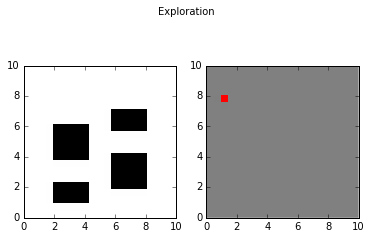

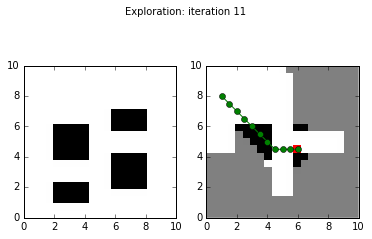

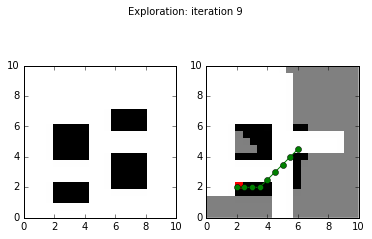

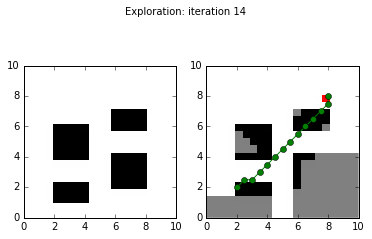

In [39]:
# grid world with obstacles
width = 10
height = 10
resolution = 0.5
x_init = (0,0)
x_goal = (8,8)
obstacles = [((6,6),(8,7)),((2,1),(4,2)),((2,4),(4,6)),((6,2),(8,4))]
world = DetOccupancyGrid2D(width, height, obstacles, resolution)

rrange = 3
walle = explorer(world, rrange)
walle.run(3)